In [61]:
import xarray as xr 
import numpy as np 
import os

import matplotlib.pyplot as plt

In [62]:
file = '/home/hanna/miphclac/2004_07/2004_07_tcc.nc'  

In [63]:
data = xr.open_dataset(file)

In [64]:
data

<xarray.Dataset>
Dimensions:    (latitude: 81, longitude: 161, time: 743)
Coordinates:
  * time       (time) datetime64[ns] 2004-07-01 ... 2004-07-31T23:00:00
  * longitude  (longitude) float64 -15.0 -14.75 -14.5 -14.25 ... 24.5 24.75 25.0
  * latitude   (latitude) float64 30.0 30.25 30.5 30.75 ... 49.5 49.75 50.0
Data variables:
    tcc        (time, latitude, longitude) float64 ...
    nr_nans    (time, latitude, longitude) float64 ...

In [65]:
data.max()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    tcc      float64 1.0
    nr_nans  float64 0.0

In [66]:
data.min()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    tcc      float64 0.0
    nr_nans  float64 0.0

In [67]:
clouds = data.sel(time = '2004-07-02T12')

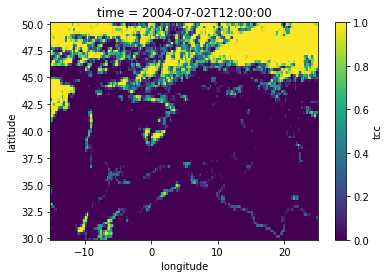

In [68]:
clouds['tcc'].plot()
plt.savefig('/home/hanna/MS-figures/example_artefact.png')

## Read in Filter and check

In [19]:
import glob
import os

In [20]:
filter_dir = '/home/hanna/MS-suppl/filters/'

# TODO : Store the land.nc file

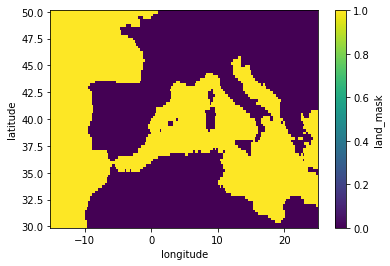

In [114]:
mask = xr.open_dataset(glob.glob(os.path.join(filter_dir, '*land*50*.nc'))[-1])
mask = mask.sel(latitude = slice(30, 50), longitude = slice(-15,25))
mask['land_mask'].plot()

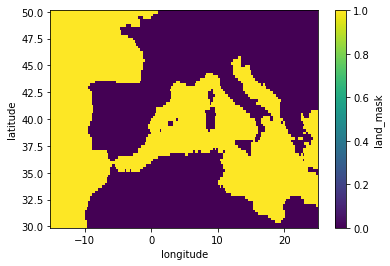

In [111]:

mask.land_mask.values[mask.land_mask.values < 0.5] = 0
mask.land_mask.values[mask.land_mask.values > 0.5] = 1
#mask.to_netcdf(path = os.path.join(filter_dir, 'sea.nc'))


## Locating artefact by using linear theshold 

In [53]:
mask2 = mask.where(mask.latitude + 1/3*mask.longitude < 40, 0)
mask2 = mask2.where(mask2.land_mask <= 0, 1) # rounds all values to 1
mask2.to_netcdf(path = os.path.join(filter_dir, 'artefact.nc'))

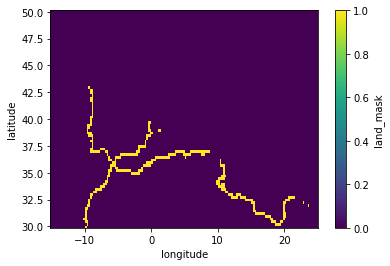

In [51]:
mask2['land_mask'].plot()

# Coastline filter 
## Everything that is not 100 percent land sea

In [54]:
coast = mask.copy()

In [55]:
coast.land_mask.values[coast.land_mask.values < 0.01] = 0
coast.land_mask.values[coast.land_mask.values > 0.99] = 0
coast = coast.where(coast.land_mask <= 0, 1) # rounds all values to 1

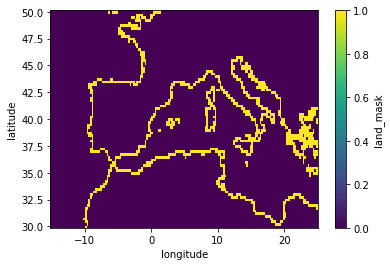

In [56]:
coast['land_mask'].plot()

In [57]:
coast.to_netcdf(path = os.path.join(filter_dir, 'coastline.nc'))

In [69]:
ll

array([[False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])

In [83]:
class Filter:
    
    def __init__(self, dataset = None, key = 'artefact', in_place = True):
        valid_keys  = ['land', 'sea', 'coast', 'artefact']
        self.key = key
        self.dataset = dataset
        self.in_place = in_place
        if key not in valid_keys:
            raise ValueError('Unvalid key. Valid keys are {}'.format(valid_keys))
            
        filter_files = glob.glob('/home/hanna/MS-suppl/*{}*.nc'.format(key))
        assert len(filter_files) != 0, "Detected muliple files, double check names in MS-suppl."
        
        filter_ds = xr.open_dataset(filter_files[0])
        
        dataset['filtered_{}'.format(key)] = dataset['tcc']*filter_ds['land_mask']
        
        return dataset
        

In [88]:
def filter_dataset(dataset, key = 'artefact', inplace = True):
    """ Filter datasets 
    
    TODO: extend the functionality to handle multiple filters 
    
    if type is list  or str
    
    """
    valid_keys  = ['land', 'sea', 'coast', 'artefact']

    if key not in valid_keys:
        raise ValueError('Unvalid key. Valid keys are {}'.format(valid_keys))

    filter_files = glob.glob('/home/hanna/MS-suppl/filters/*{}*.nc'.format(key))
    print(filter_files)
    assert len(filter_files) != 0, "Detected muliple files, double check names in MS-suppl."

    filter_ds = xr.open_dataset(filter_files[0])

    dataset['filtered_{}'.format(key)] = dataset['tcc']*filter_ds['land_mask']

    return dataset

In [94]:
test = filter_dataset(data, key = 'artefact', inplace = True)

['/home/hanna/MS-suppl/filters/artefact.nc']


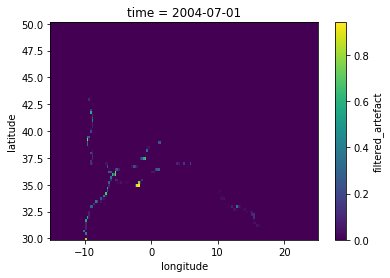

In [97]:
test['filtered_artefact'].isel(time = 0).plot()

In [100]:
plt.histogram(test['filtered_artefact'].sum(dim = ['latitude', 'longitude']), 10 )

AttributeError: module 'matplotlib.pyplot' has no attribute 'histogram'

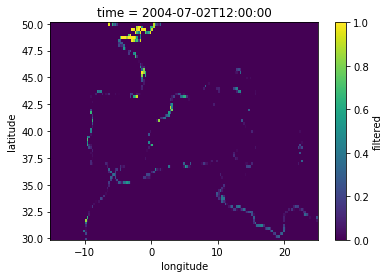

In [72]:
clouds['filtered'].plot()